### Import thư viện

In [286]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [287]:
df = pd.read_csv('BTC-USD_w.csv')
df = df.sort_values('Date').reset_index(drop=True)

In [288]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-15,465.864014,468.174011,384.532013,398.821014,398.821014,156903400
1,2014-09-22,399.100006,441.557007,374.332001,377.181000,377.181000,186772600
2,2014-09-29,376.928009,391.378998,289.295990,320.510010,320.510010,276657896
3,2014-10-06,320.389008,382.726013,302.559998,378.549011,378.549011,341152804
4,2014-10-13,377.920990,411.697998,368.897003,389.545990,389.545990,156902070


In [289]:
df.shape

(404, 7)

### Vẽ biểu đồ giá theo giá đóng của

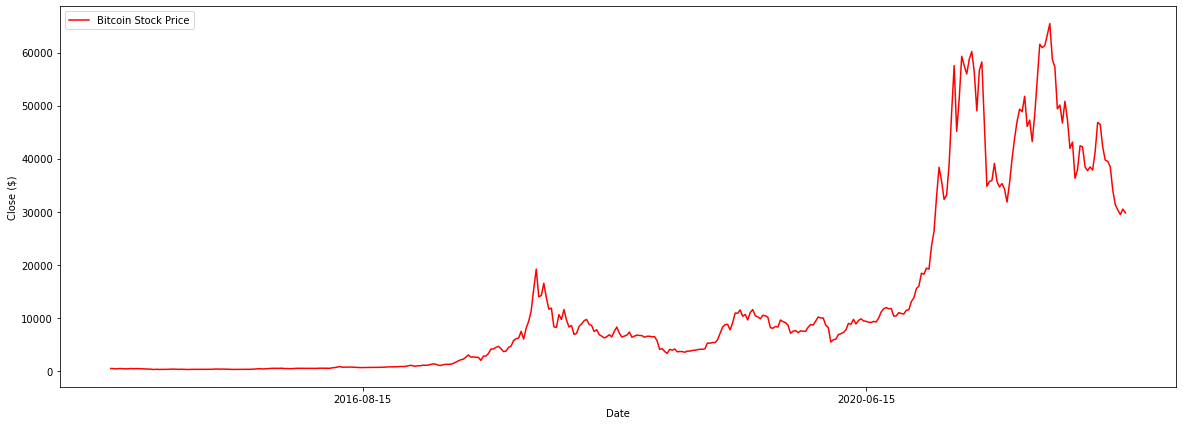

In [290]:
#giá đóng cửa
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Bitcoin Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

### Data Preprocessing

In [291]:
num_shape = 280
train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [292]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [293]:
X_train = []

#Price on next day
y_train = []

window = 8

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

### Recurrent Neural Network

#### Training of the basic LSTM model

In [294]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 8, 50)             10400     
                                                                 
 dropout_72 (Dropout)        (None, 8, 50)             0         
                                                                 
 lstm_45 (LSTM)              (None, 8, 50)             20200     
                                                                 
 dropout_73 (Dropout)        (None, 8, 50)             0         
                                                                 
 lstm_46 (LSTM)              (None, 8, 50)             20200     
                                                                 
 dropout_74 (Dropout)        (None, 8, 50)             0         
                                                                 
 lstm_47 (LSTM)              (None, 50)              

In [295]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32);

Epoch 1/100
9/9 [==============================] - 5s 14ms/step - loss: 0.0571
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0262
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0134
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0122
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0107
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 7/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0100
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0082
Epoch 9/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0093
Epoch 10/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0082
Epoch 11/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0082
Epoch 12/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0077
Epoch 13/100
9/9 [==============================]

#### Prediction

In [296]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [297]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

4/4 [==============================] - 1s 5ms/step


In [298]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 317730619.32066435
MAE: 13913.44407612802
RMSE: 17824.999840691846


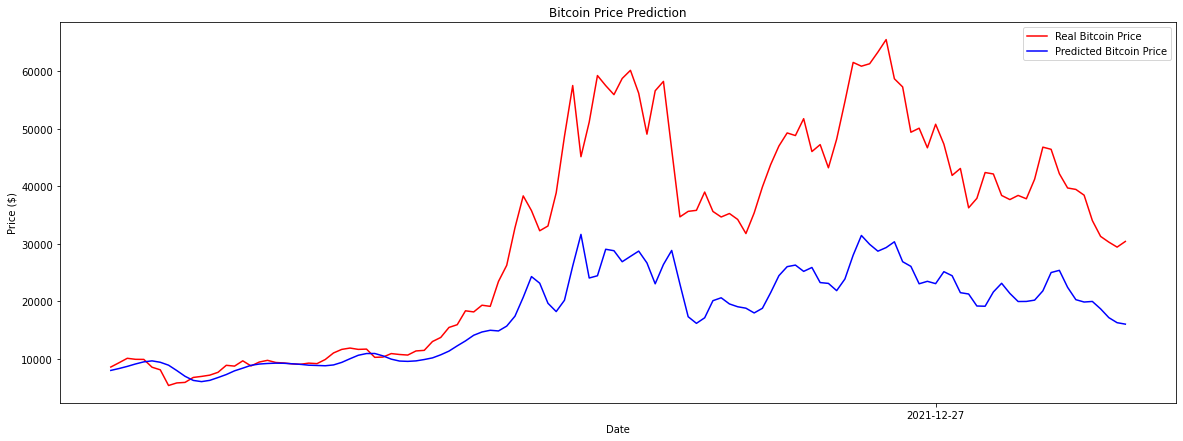

In [299]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[280:], df_volume[280:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[300:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [300]:
pred_ = predict[-1].copy()
prediction_full = []
window = 8
df_copy = df.iloc[:, 1:2][1:].values

for j in range(3):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

4/4 [==============================] - 0s 5ms/step


In [301]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [302]:
df_date = df[['Date']]

for h in range(3):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

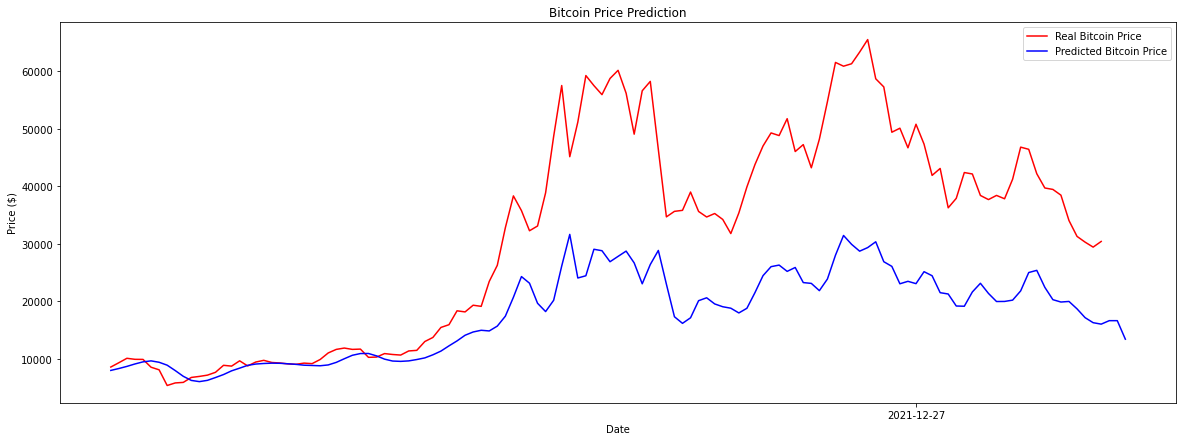

In [303]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[280:], df_volume[280:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[300:].shape[0],200))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

### GRU

In [304]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 8, 50)             7950      
                                                                 
 dropout_76 (Dropout)        (None, 8, 50)             0         
                                                                 
 gru_29 (GRU)                (None, 8, 50)             15300     
                                                                 
 dropout_77 (Dropout)        (None, 8, 50)             0         
                                                                 
 gru_30 (GRU)                (None, 8, 50)             15300     
                                                                 
 dropout_78 (Dropout)        (None, 8, 50)             0         
                                                                 
 gru_31 (GRU)                (None, 50)              

In [305]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
17/17 [==============================] - 4s 8ms/step - loss: 0.0270
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 10/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 11/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 12/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 13/100
17/17 [=================

In [306]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

4/4 [==============================] - 1s 4ms/step


In [307]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 57340764.03538349
MAE: 5209.649748801662
RMSE: 7572.368456129396


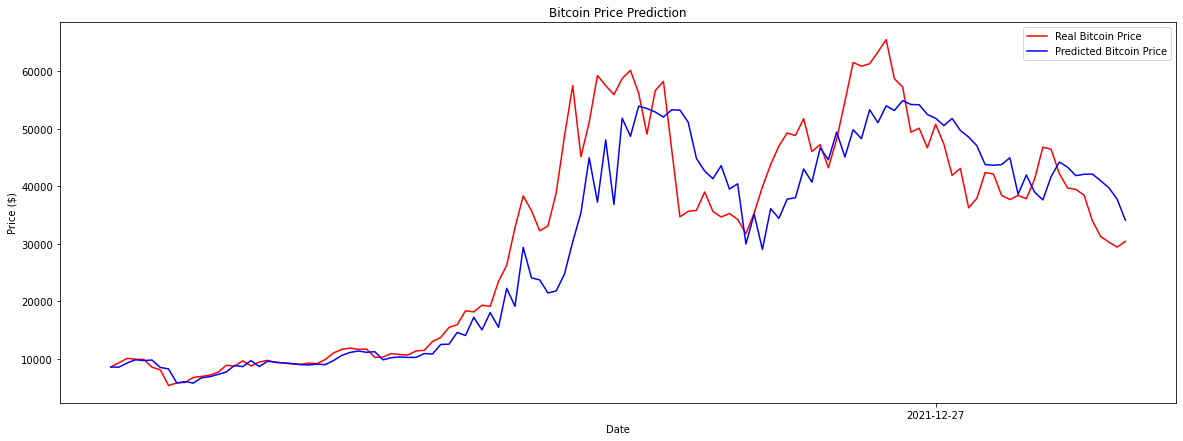

In [308]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[280:], df_volume[280:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[300:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [309]:
pred_ = predict[-1].copy()
prediction_full = []
window = 8
df_copy = df.iloc[:, 1:2][1:].values

for j in range(3):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

4/4 [==============================] - 0s 4ms/step


In [310]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(3):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

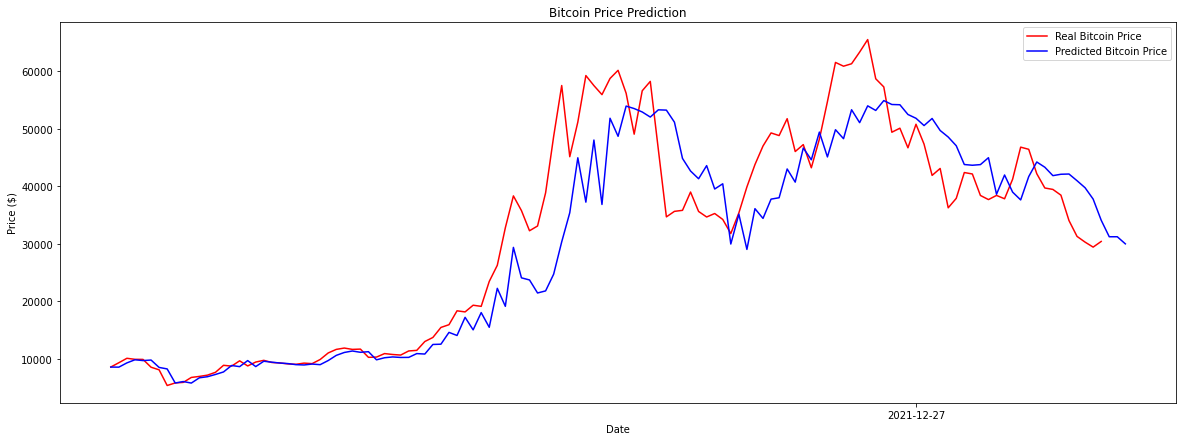

In [311]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[280:], df_volume[280:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df_date[300:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()